# 🐶 Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds


To do this, we'll be using data from the [Kaggle dog breed identification competition]. It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:
1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub. 

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**.

# It is Transfer Learning

## Getting our workspace ready

Before we get started, since we'll be using TensorFlow 2.x and TensorFlow Hub (TensorFlow Hub), let's import them.

In [1]:
# At time of recording, TF 2.x is not the default
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.8.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.8.2
Hub version: 0.12.0
GPU available (YESS!!!!)


## Getting data ready

Since much of machine learning is getting your data ready to be used with a machine learning model, we'll take extra care getting it setup.

### Importing Pandas and importing for data (labels from label.csv)

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog_vision_project_required_stuffs/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


Looking at this, we can see there are 10222 different ID's (meaning 10222 different images) and 120 different breeds.

Let's figure out how many images there are of each breed.

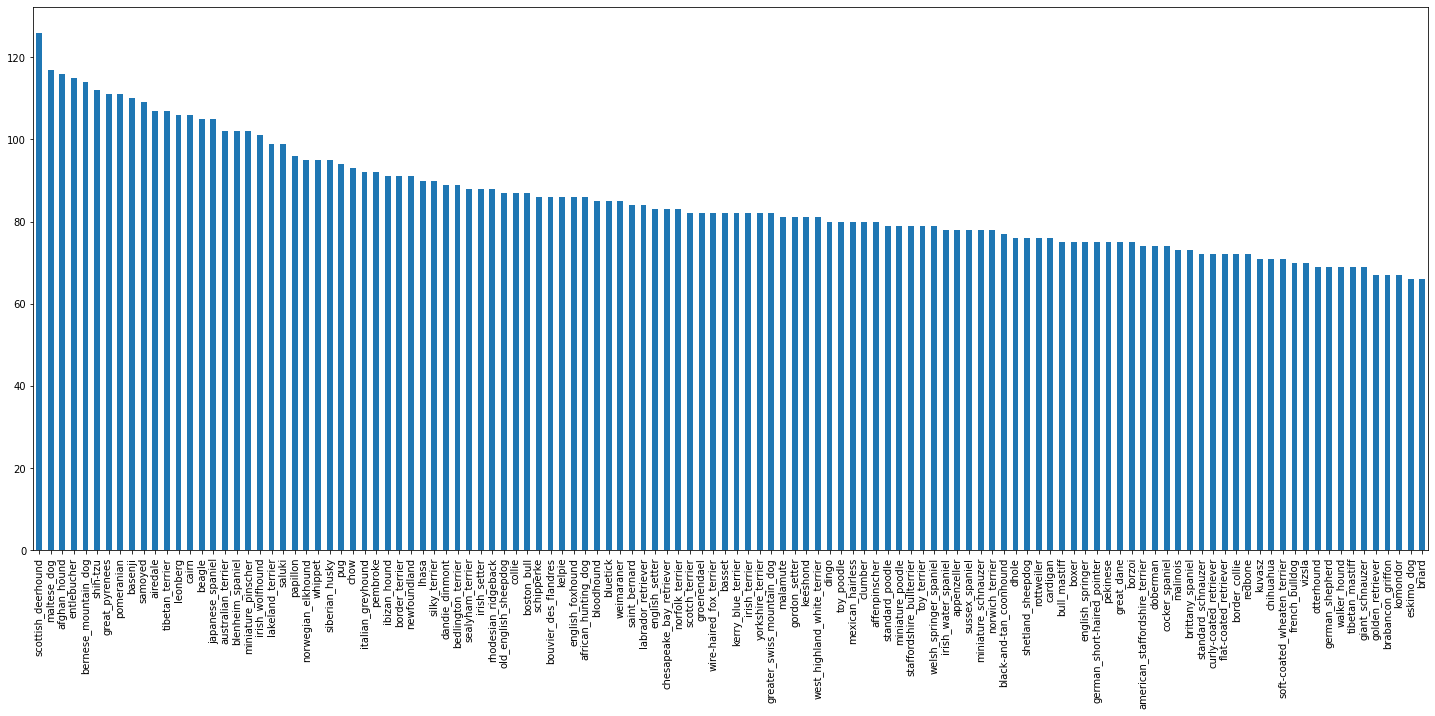

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(25, 10));

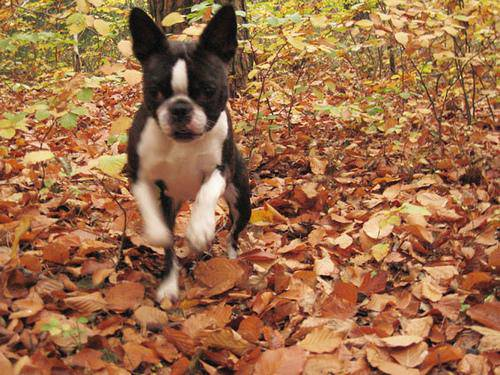

In [6]:
from IPython.display import display, Image
Image("/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [7]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog_vision_project_required_st

In [8]:
filenames[1000]

'/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/18acb0833a0f70b25b772c383a5c49df.jpg'

Now we've got a list of all the filenames from the ID column of `labels_csv`, we can compare it to the number of files in our training data directory to see if they line up.

In [9]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


If everything worked, we should see a match up.

Let's do one more check. Visualizing directly from a filepath.

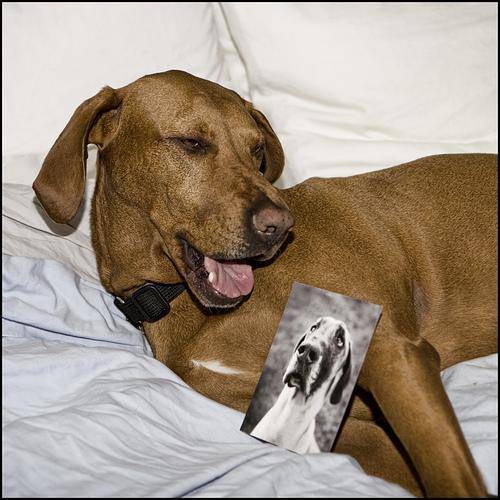

In [10]:
# Check an image directly from a filepath
Image(filenames[100])


Now we've got our image filepaths together, let's get the labels.

We'll take them from `labels_csv` and turn them into a NumPy array.

In [11]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [12]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers. 

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

In [13]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [14]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

The length of `unique_breeds` should be 120, meaning we're working with images of 120 different breeds of dogs.

Now use `unique_breeds` to help turn our `labels` array into an array of booleans.

In [15]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

### Coverting all labels to bolean for further process

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Why do it like this?

Remember, an important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In this case, we've transformed a single dog breed name such as `boston_bull` into a one-hot array. 

Let's see an example.

In [17]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Splitting Our Data

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set), let's make one.

For accessibility later, let's save our filenames variable to `X` (data) and our labels to `y`.

In [18]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 2000 and increase it as we need.

In [19]:
# Set number of images to use for experimenting
NUM_IMAGES = 2000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

2000

Now let's split our data into training and validation sets. We'll use and 80/20 split (80% training data, 20% validation data).

In [20]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(1600, 1600, 400, 400)

In [21]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/17c5e8815cf0d086090a07b003b9b036.jpg',
  '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/0593e37870ee77b0d34508e118bf6670.jpg',
  '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/1428026a4472cda58ad13233bb9ad64d.jpg',
  '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/10f1d53bb20d5acc7c8772018399c238.jpg',
  '/content/drive/MyDrive/Dog_vision_project_required_stuffs/train/0a1b0b7df2918d543347050ad8b16051.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, 

### Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.


Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.



In [22]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[1]) # read in an image
image.shape

(375, 500, 3)

Notice the shape of `image`. It's (375, 500, 3). This is height, width, colour channel value. 

And you can easily convert it to a Tensor using [`tf.constant()`](https://www.tensorflow.org/api_docs/python/tf/constant).

In [23]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[ 51,  34,  27],
        [ 55,  38,  30],
        [ 61,  42,  35],
        ...,
        [128,  92,  60],
        [ 78,  42,  10],
        [168, 132, 100]],

       [[ 62,  45,  37],
        [ 64,  45,  38],
        [ 63,  45,  35],
        ...,
        [115,  81,  53],
        [ 46,  12,   0],
        [ 73,  39,  11]]], dtype=uint8)>

Ok, now let's build that function

In [24]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Creating data batches

We are going to split the batches and train out model, batch is to split the data into smaller pieces like

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of `process_image` function at the same time.

In [25]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [26]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [27]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [28]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [29]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))



### Visualizing data batches

In [30]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

We are going to use the as_numpy_iterator() help us to unwind the batch data individually

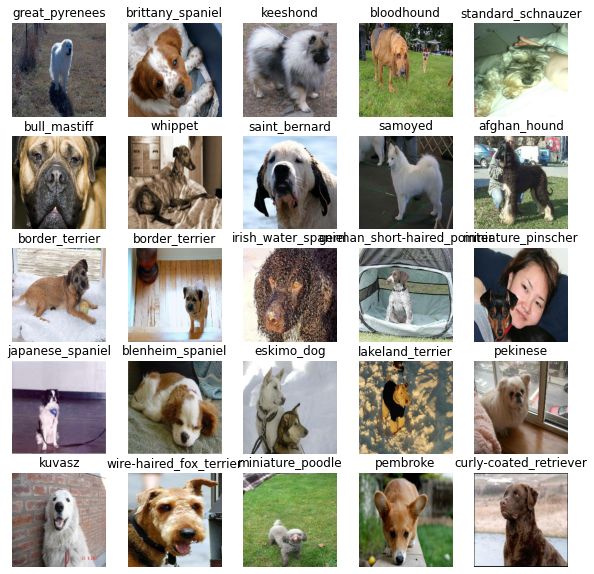

In [31]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

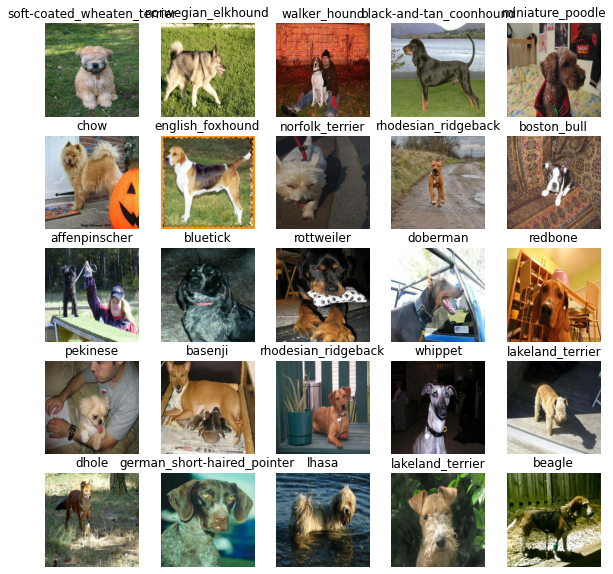

In [32]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as **transfer learning**.

#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning gives the better approach to do the process effectively

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.




In [33]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [34]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [35]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


The non-trainable parameters are the patterns learned by `mobilenet_v2_130_224` and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

# Going to use the callbacks to detect the progression of training of our model

In [36]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [37]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback




In [38]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

### Training a model (on a subset of data)


We are going to give the Epoch of 100

In [39]:
# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESS!!!!)


In [40]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [41]:
# Build a function to train and return a trained model
def train_model():
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [42]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
50/50 [==============================] - 117s 1s/step - loss: 3.6687 - accuracy: 0.2431 - val_loss: 1.8115 - val_accuracy: 0.5925
Epoch 2/100
50/50 [==============================] - 6s 128ms/step - loss: 0.8599 - accuracy: 0.8350 - val_loss: 1.1293 - val_accuracy: 0.7300
Epoch 3/100
50/50 [==============================] - 6s 128ms/step - loss: 0.3328 - accuracy: 0.9606 - val_loss: 0.9769 - val_accuracy: 0.7350
Epoch 4/100
50/50 [==============================] - 6s 129ms/step - loss: 0.1755 - accuracy: 0.9906 - val_loss: 0.9147 - val_accuracy: 0.7550
Epoch 5/100
50/50 [==============================] - 7s 130ms/step - loss: 0.1106 - accuracy: 0.9969 - val_loss: 0.8822 - val_accuracy: 0.7500
Epoch 6/100
50/50 [==============================] - 7s 128ms/step - loss: 0.0786 - accuracy: 0.9994 - val_loss: 0.8617 - val_accuracy: 0.7625
Epoch 7/100
50/50 [==============================]

Thanks to our `early_stopping` callback, the model stopped training after 12 or so epochs (in my case, yours might be slightly different). This is because the validation accuracy failed to improve for 3 epochs.

But the good new is, we can definitely see our model is learning something. The validation accuracy got to 77% in only a few minutes.

This means, if we were to scale up the number of images, hopefully we'd see the accuracy increase.

## Making and evaluating predictions using a trained model

Making the Prediction 

In [44]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

13/13 [==============================] - 11s 102ms/step


array([[1.7894844e-04, 7.6862447e-02, 2.2041294e-04, ..., 4.8851641e-04,
        2.2829221e-05, 5.7418802e-06],
       [5.3140679e-06, 1.2998091e-06, 2.8190294e-05, ..., 1.1038461e-06,
        1.0985973e-06, 2.5202096e-06],
       [2.9176397e-06, 4.4501110e-04, 5.4923166e-03, ..., 6.3123450e-02,
        7.1468552e-05, 7.4219955e-08],
       ...,
       [3.7758605e-06, 4.6452080e-04, 2.5762385e-05, ..., 2.2609751e-05,
        1.7013168e-04, 1.4587160e-04],
       [9.5783340e-05, 1.1432381e-05, 1.1070198e-05, ..., 1.7895094e-04,
        2.7462951e-04, 6.1057333e-05],
       [1.8984170e-05, 9.4320596e-05, 9.3474242e-08, ..., 1.0156335e-06,
        2.0636838e-07, 1.2051626e-07]], dtype=float32)

In [45]:
# Check the shape of predictions
predictions.shape

(400, 120)

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (400 images) returns an array (`predictions`) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

Coverting our array into actual label

In [46]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[1.78948438e-04 7.68624470e-02 2.20412941e-04 3.00135434e-04
 2.60700152e-04 7.17819876e-06 6.55834301e-05 1.50011474e-04
 8.46429175e-05 2.67918076e-04 1.47769810e-03 6.99578959e-05
 3.05678186e-05 6.40861908e-05 3.96649819e-04 1.07125325e-05
 3.96449395e-05 1.69496182e-02 1.18220400e-04 4.71312815e-05
 7.57199377e-02 2.31486280e-03 3.90249043e-05 1.13379955e-01
 6.30283394e-05 7.33696995e-03 5.25102466e-02 2.77917898e-05
 6.59195284e-05 1.91804111e-06 1.17470697e-03 9.21685350e-05
 1.03402149e-03 1.39258220e-04 2.91301287e-04 1.12115797e-02
 4.72637248e-06 1.48188177e-04 3.96614487e-04 1.85703582e-04
 2.84774811e-04 1.62666511e-05 8.97611317e-04 8.24803137e-04
 1.17763939e-05 1.50192704e-04 1.25184946e-04 3.81648315e-05
 8.49823933e-04 4.64311452e-04 9.22203799e-06 1.12041296e-03
 2.85513420e-03 1.01948135e-04 2.93923134e-04 8.67299059e-06
 4.37234557e-05 1.51871282e-04 4.96128268e-05 2.39973073e-03
 9.50371686e-05 1.29605341e-05 1.02833881e-04 1.13398264e-05
 4.60975891e-04 1.045326

In [47]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'soft-coated_wheaten_terrier'

In [48]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.28940946, 0.3325467 , 0.17568396],
         [0.2501433 , 0.29330748, 0.13644473],
         [0.2876167 , 0.33420166, 0.17733891],
         ...,
         [0.5164206 , 0.5776601 , 0.33903962],
         [0.54773974, 0.6089793 , 0.3703588 ],
         [0.50159407, 0.56283355, 0.32421306]],
 
        [[0.27667817, 0.32765856, 0.15903112],
         [0.30975384, 0.3608085 , 0.19218104],
         [0.33957785, 0.39721096, 0.22858347],
         ...,
         [0.491509  , 0.5575804 , 0.28604677],
         [0.5702347 , 0.6363061 , 0.36477253],
         [0.5313855 , 0.59745693, 0.32592332]],
 
        [[0.29069865, 0.35518688, 0.17861006],
         [0.29807582, 0.36118335, 0.18470922],
         [0.31007844, 0.37737536, 0.20058963],
         ...,
         [0.50055254, 0.56690407, 0.29036346],
         [0.5573835 , 0.623735  , 0.34719437],
         [0.55167574, 0.61802727, 0.34148666]],
 
        ...,
 
        [[0.24473517, 0.27916905, 0.13407102],
         [0.04194384, 0.08529994, 0.00537

##function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [49]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

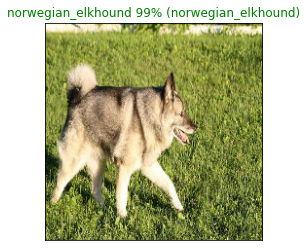

In [50]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

Nice! Making functions to help visual your models results are really helpful in understanding how your model is doing.

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:
* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [51]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

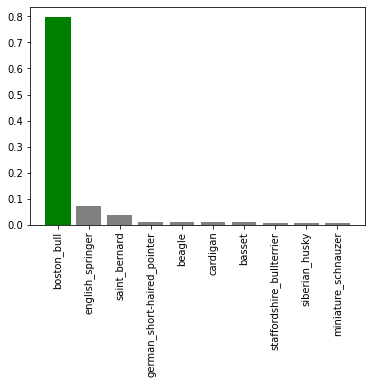

In [52]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Wonderful! Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

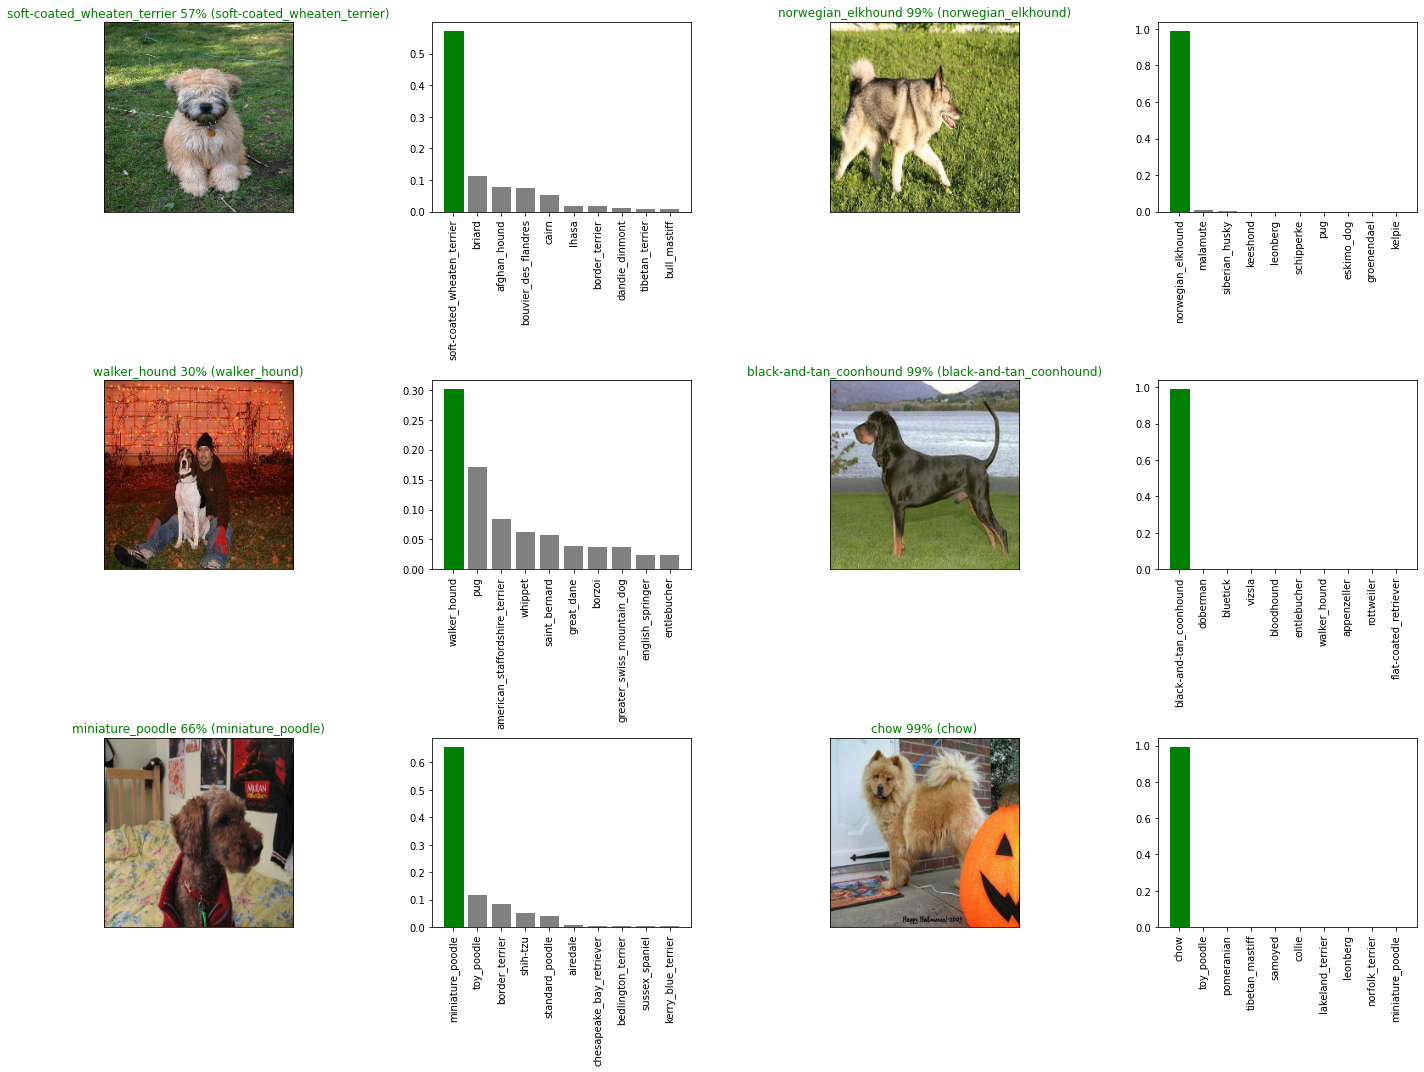

In [53]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an [entire saved Keras model is h5](https://www.tensorflow.org/tutorials/keras/save_and_load). So we'll make a function which can take a model as input and utilise the [`save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) method to save it as a h5 file to a specified directory.

In [54]:
def save_model(model, suffix=None):
  # Create model directory with current time
  modeldir = os.path.join("/content/drive/MyDrive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [55]:
def load_model(model_path):
  
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [56]:
# Save our model trained on 2000 images
save_model(model, suffix="2000-images-Adam")

Saving model to: /content/drive/MyDrive/Data/models/20220625-01591656122361-2000-images-Adam.h5...


'/content/drive/MyDrive/Data/models/20220625-01591656122361-2000-images-Adam.h5'

In [57]:
# Load our model trained on 1000 images
model_1000_images = load_model('/content/drive/MyDrive/Data/models/20220624-06121656051139-2000-images-Adam.h5')

Loading saved model from: /content/drive/MyDrive/Data/models/20220624-06121656051139-2000-images-Adam.h5


Compare the two models (the original one and loaded one). We can do so easily using the `evaluate()` method.

In [58]:
# Evaluate the pre-saved model
model.evaluate(val_data)

13/13 [==============================] - 1s 88ms/step - loss: 0.8223 - accuracy: 0.7675


[0.8223375082015991, 0.7674999833106995]

In [59]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

13/13 [==============================] - 2s 86ms/step - loss: 0.8203 - accuracy: 0.7850


[0.8203397393226624, 0.7850000262260437]

## Training a model (on the full data)

Now we know our model works on a subset of the data, we can start to move forward with training one on the full data.

Above, we saved all of the training filepaths to `X` and all of the training labels to `y`. Let's check them out.

In [60]:
# Remind ourselves of the size of the full dataset
len(X), len(y)

(10222, 10222)

There we go! We've got over 10,000 images and labels in our training set.

Before we can train a model on these, we'll have to turn them into a data batch.

In [61]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


Our data is in a data batch, all we need now is a model.

And surprise, we've got a function for that too! Let's use `create_model()` to instantiate another model. 

In [62]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


Since we've made a new model instance, `full_model`, we'll need some callbacks too.

In [63]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

To monitor the model whilst it trains, we'll load TensorBoard (it should update every 30-seconds or so whilst the model trains).

**Note:** Since running the cell below will cause the model to train on all of the data (10,000+) images, it may take a fairly long time to get started and finish. However, thanks to our `full_model_early_stopping` callback, it'll stop before it starts going too long.

Remember, the first epoch is always the longest as data gets loaded into memory. After it's there, it'll speed up.

In [65]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 38s 108ms/step - loss: 1.3536 - accuracy: 0.6664
Epoch 2/100
320/320 [==============================] - 35s 109ms/step - loss: 0.4020 - accuracy: 0.8836
Epoch 3/100
320/320 [==============================] - 36s 113ms/step - loss: 0.2379 - accuracy: 0.9342
Epoch 4/100
320/320 [==============================] - 40s 124ms/step - loss: 0.1550 - accuracy: 0.9602
Epoch 5/100
320/320 [==============================] - 39s 122ms/step - loss: 0.1067 - accuracy: 0.9784
Epoch 6/100
320/320 [==============================] - 39s 121ms/step - loss: 0.0771 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 41s 127ms/step - loss: 0.0599 - accuracy: 0.9906
Epoch 8/100
320/320 [==============================] - 39s 123ms/step - loss: 0.0464 - accuracy: 0.9933
Epoch 9/100
320/320 [==============================] - 40s 125ms/step - loss: 0.0370 - accuracy: 0.9961
Epoch 10/100
320/320 [==============================] - 38s 120m

### Saving and reloading the full model



In [66]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: /content/drive/MyDrive/Data/models/20220625-02121656123132-all-images-Adam.h5...


'/content/drive/MyDrive/Data/models/20220625-02121656123132-all-images-Adam.h5'

Saving model to: /content/drive/MyDrive/Data/models/20220625-02121656123132-all-images-Adam.h5...


'/content/drive/MyDrive/Data/models/20220625-02121656123132-all-images-Adam.h5'

In [67]:
# Load in the full model
loaded_full_model = load_model('/content/drive/MyDrive/Data/models/20220624-06451656053134-all-images-Adam.h5')

Loading saved model from: /content/drive/MyDrive/Data/models/20220624-06451656053134-all-images-Adam.h5
Loading saved model from: /content/drive/MyDrive/Data/models/20220624-06451656053134-all-images-Adam.h5


### Making predictions on the test dataset


In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "/content/drive/MyDrive/Dog_vision_project_required_stuffs/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

In [ ]:
# How many test images are there?
len(test_filenames)

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

In [72]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,verbose=1)

324/324 [==============================] - 42s 129ms/step


In [73]:
# Check out the test predictions
test_predictions[:10]

array([[1.1051328e-12, 7.7347673e-10, 1.5911038e-11, ..., 8.2519243e-12,
        4.6898103e-07, 1.5857450e-10],
       [1.9495747e-15, 3.1970970e-09, 6.4217603e-12, ..., 5.2886646e-09,
        3.3321237e-09, 4.0858781e-15],
       [1.2098834e-05, 2.6094705e-07, 1.9834417e-14, ..., 1.3312831e-16,
        6.2332466e-17, 4.6919395e-12],
       ...,
       [1.1397471e-14, 1.5070822e-05, 4.7418525e-13, ..., 1.6504250e-09,
        3.9060435e-13, 6.7407690e-12],
       [4.8921830e-12, 7.8960016e-12, 4.4373183e-10, ..., 2.4455984e-10,
        4.0757079e-08, 5.0660881e-10],
       [2.6704974e-08, 1.8926489e-11, 1.0421156e-09, ..., 1.1171235e-12,
        3.0288735e-10, 8.0559792e-10]], dtype=float32)

In [74]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [75]:
# Append test image ID's to predictions DataFrame
test_path = "/content/drive/MyDrive/Dog_vision_project_required_stuffs/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e5b8269cbd9b417dd00e8661206b91ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e05367db91d0449b2afe76a1b7acc1c8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e4b76574d24800b91bdcfc886fb74f23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e137b0cd96051765c349377725c4696d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dce52d7235885d9ad2ae34006e2ecb1e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e5b8269cbd9b417dd00e8661206b91ff,1.105133e-12,7.734767e-10,1.591104e-11,7.256239e-10,1.259754e-09,4.094556e-15,1.148793e-12,1.542637e-10,4.045212e-10,...,2.226358e-08,5.788955e-13,9.698731e-12,3.077893e-10,1.709782e-10,1.460128e-13,8.846667e-10,8.251924e-12,4.689810e-07,1.585745e-10
1,e05367db91d0449b2afe76a1b7acc1c8,1.949575e-15,3.197097e-09,6.421760e-12,5.998579e-10,3.156455e-15,8.269976e-12,7.714392e-12,4.137843e-15,3.245676e-11,...,8.331981e-11,1.606441e-11,2.873718e-10,2.156019e-12,2.211734e-07,3.145903e-13,2.931995e-14,5.288665e-09,3.332124e-09,4.085878e-15
2,e4b76574d24800b91bdcfc886fb74f23,1.209883e-05,2.609470e-07,1.983442e-14,4.834861e-12,1.292127e-12,7.552686e-08,3.109665e-12,3.137367e-12,3.595879e-11,...,3.574758e-06,5.589958e-11,1.675014e-14,7.079988e-13,2.264683e-13,6.254377e-16,3.516249e-14,1.331283e-16,6.233247e-17,4.691940e-12
3,e137b0cd96051765c349377725c4696d,4.957506e-11,2.941107e-09,5.977649e-10,2.332268e-09,4.972189e-09,3.153696e-11,9.930597e-10,6.531694e-09,5.407938e-12,...,3.038968e-09,4.856626e-10,3.086618e-10,2.735321e-11,1.995912e-11,9.525211e-12,3.355544e-10,1.031324e-11,2.666763e-06,2.047811e-09
4,dce52d7235885d9ad2ae34006e2ecb1e,6.359979e-08,2.958661e-06,2.395021e-06,2.006198e-08,1.093196e-11,3.976621e-11,8.618709e-08,3.920261e-14,4.832276e-11,...,3.830584e-12,1.613046e-16,7.070279e-12,2.473639e-09,6.598671e-10,1.408728e-12,1.114208e-10,2.573483e-09,2.828449e-15,2.747480e-09


In [77]:
preds_df.to_csv("drive/My Drive/Data/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

## Making predictions on custom images


The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

* Get the filepaths of our own images.
* Turn the filepaths into data batches using *create_data_batches()*. And since our custom images won't have labels, we set the *test_data* parameter to *True*.
* Pass the custom image data batch to our model's *predict()* method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.


In [78]:
# Get custom image filepaths
custom_path = "/content/drive/MyDrive/Dog_vision_project_required_stuffs/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [79]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [80]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

Now we've got some predictions arrays, let's convert them to labels and compare them with each image.

In [81]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['english_foxhound',
 'yorkshire_terrier',
 'german_shepherd',
 'boxer',
 'golden_retriever',
 'bull_mastiff']

In [82]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

ValueError: ignored

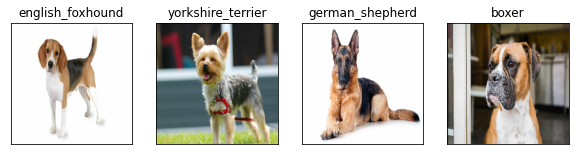

In [86]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

##So we have predicted our Custom data with their labels our Model performed well

##So Classification of Different Breeds of Dogs are done😊😊